In [1]:
import scipy
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
from librosa.core import resample

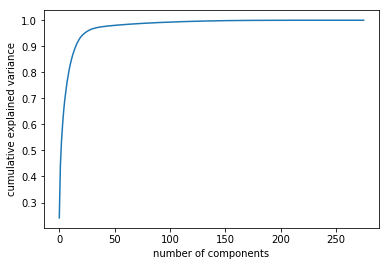

In [4]:
sample_rate, samples = wavfile.read('audio_mixed.wav')
samples_casted = samples / (2.**15) 
seg_len = sample_rate/40 #25ms
overlap = seg_len*0.6  #60% overlap
f, t, Zxx = signal.stft(samples_casted, fs = sample_rate, nperseg = seg_len, noverlap = overlap)
Zxx_abs = np.abs(Zxx)
output = Zxx
from sklearn.decomposition import PCA
pca = PCA().fit(output.real)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [5]:
#choose n = 30 for PCA
output_real = np.abs(output.transpose())
# print(output_real)
pca = PCA(n_components = 30, svd_solver='full')
audio_pca = pca.fit_transform(output_real)
print(audio_pca[0], '\n', audio_pca.shape)
print(sum(pca.explained_variance_ratio_))

[-2.1025123e-06 -4.6801779e-07  1.5155710e-07 -2.4543237e-08
 -2.3933922e-07 -1.7972582e-07 -2.3834650e-07  2.3879713e-07
 -1.2641335e-07 -1.4912732e-07  2.1383606e-07  3.4190180e-08
  5.5361816e-08  1.1230981e-07 -3.7223877e-08 -4.4636610e-09
 -2.6338247e-07 -1.2069472e-07  2.7332983e-09  1.8669969e-07
 -5.7835152e-08 -6.0743666e-08 -8.3887919e-08 -8.5076358e-08
 -8.1773521e-08 -1.0795893e-07 -1.4695250e-08 -4.3828322e-08
 -5.6560436e-09 -1.4024403e-08] 
 (23947, 30)
0.9387716772034764


In [7]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
kmeans = KMeans(n_clusters=10, random_state=0).fit(audio_pca)

In [8]:
labels_k = kmeans.labels_
print(labels_k, '\n', len(labels_k), '\n', kmeans.cluster_centers_)
centers = kmeans.cluster_centers_
indices = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
points = {i: audio_pca[np.where(kmeans.labels_ == i)] for i in range(kmeans.n_clusters)}
min_indices = {}
for i in range(kmeans.n_clusters):
    distances = [np.linalg.norm(a-centers[i]) for a in points[i]]
    min_indices[i] = distances.index(min(distances))
print(indices, '\n', points,'\n',min_indices)

[1 8 1 ... 4 0 1] 
 23947 
 [[ 1.64060123e-06  5.04202603e-07 -2.19607529e-07 -9.49175103e-08
  -7.18067028e-08  8.97104613e-08 -1.11241629e-08 -5.07088460e-09
  -2.45237803e-08 -1.75529244e-08  2.63942859e-08 -1.37560763e-08
   6.36858744e-09 -1.13803234e-08 -1.52412216e-08 -3.91562294e-09
  -4.01106970e-09  6.46317710e-09  5.93358562e-09  4.81234963e-09
   4.01539024e-10 -3.18533311e-09  2.41473574e-09  7.37259942e-09
   5.09432274e-10 -2.55334864e-09 -4.78541917e-09 -1.07624221e-09
   4.40816361e-09  2.08589146e-09]
 [-9.74126806e-07 -3.82831644e-07  2.25048780e-08 -4.70628763e-08
  -1.33030611e-07  7.79818077e-09 -5.58646907e-09  6.24334673e-09
  -9.72213154e-09 -1.07466480e-08 -5.08088016e-09  1.05636155e-09
  -2.14204254e-09  9.38568334e-09 -6.09444761e-09 -5.36814726e-09
  -1.00009123e-09 -2.91839952e-09 -2.91278157e-09  2.87398993e-09
   3.27990279e-09  1.90920169e-09  4.01914235e-09 -1.22049348e-09
  -2.71791234e-09 -3.27581562e-09 -1.68772840e-09  2.20968377e-09
   2.08646012

In [9]:
import collections
print(labels_k,labels_k.shape)
collections_k = collections.Counter(labels_k)
print(collections_k)

[1 8 1 ... 4 0 1] (23947,)
Counter({1: 4899, 6: 3164, 9: 2971, 8: 2703, 7: 2688, 5: 1717, 3: 1646, 0: 1514, 4: 1397, 2: 1248})


In [10]:
#generate markov chain model
matrix = [[0 for x in range(10)] for y in range(10)] 
for i in range(len(labels_k)-1):
    matrix[labels_k[i]][labels_k[i+1]] += 1
    matrix_og = matrix[:]
for j in range(10):
    matrix[j] = [x / collections_k[j] for x in matrix_og[j]]
print(matrix)

[[0.21400264200792601, 0.04821664464993395, 0.1261558784676354, 0.058784676354029064, 0.11360634081902246, 0.04821664464993395, 0.12417437252311757, 0.1142668428005284, 0.07661822985468957, 0.07595772787318363], [0.015309246785058175, 0.3996734027352521, 0.010614411104307001, 0.028169014084507043, 0.021637068789548887, 0.05878750765462339, 0.12471933047560727, 0.08471116554398857, 0.1267605633802817, 0.12941416615635845], [0.15625, 0.044070512820512824, 0.2900641025641026, 0.06650641025641026, 0.036057692307692304, 0.03766025641025641, 0.10897435897435898, 0.17467948717948717, 0.047275641025641024, 0.038461538461538464], [0.058930741190765495, 0.07715674362089915, 0.0425273390036452, 0.28068043742405835, 0.07108140947752126, 0.08687727825030377, 0.07108140947752126, 0.12029161603888214, 0.054678007290400975, 0.13669501822600244], [0.12383679312813171, 0.06800286327845383, 0.030780243378668574, 0.09305654974946313, 0.21975662133142448, 0.06370794559770938, 0.07945597709377238, 0.0787401

In [11]:
#generate markov chain for 30 seconds
markov_generated = [5] + [0] * 2999
for i in range(len(markov_generated)):
    if i < 2999:
        prob_generated = np.random.random_sample()
        prob_comp,next_element = matrix[markov_generated[i]][0],0
        while(prob_generated > prob_comp):
            next_element+=1
            prob_comp += matrix[markov_generated[i]][next_element]
        markov_generated[i+1] = next_element
print(len(markov_generated),markov_generated)

3000 [5, 5, 5, 1, 1, 6, 5, 9, 9, 9, 1, 7, 9, 6, 6, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 8, 8, 7, 7, 2, 2, 3, 0, 0, 7, 5, 2, 7, 9, 9, 0, 7, 1, 6, 6, 7, 9, 4, 3, 3, 7, 6, 9, 4, 8, 9, 1, 9, 8, 1, 1, 2, 1, 7, 7, 7, 4, 4, 3, 0, 0, 3, 2, 7, 0, 3, 7, 6, 9, 1, 0, 6, 1, 1, 8, 0, 0, 7, 4, 4, 7, 3, 8, 6, 3, 5, 1, 1, 1, 6, 9, 1, 6, 8, 8, 1, 1, 8, 9, 4, 7, 2, 0, 0, 0, 4, 6, 7, 5, 1, 5, 7, 9, 3, 3, 9, 4, 7, 6, 6, 6, 6, 1, 1, 1, 1, 7, 7, 7, 8, 9, 6, 8, 1, 1, 8, 8, 8, 1, 6, 8, 9, 3, 1, 6, 6, 6, 5, 5, 5, 3, 2, 2, 6, 1, 1, 8, 8, 6, 6, 6, 9, 6, 6, 9, 1, 9, 9, 9, 4, 4, 0, 9, 9, 8, 4, 7, 1, 8, 6, 1, 3, 3, 3, 7, 8, 9, 5, 9, 6, 1, 1, 1, 8, 6, 6, 0, 2, 0, 2, 6, 9, 1, 6, 8, 6, 1, 1, 1, 4, 3, 3, 5, 0, 2, 8, 8, 8, 1, 1, 1, 6, 8, 6, 6, 2, 3, 9, 1, 1, 8, 9, 7, 7, 8, 0, 8, 8, 7, 7, 8, 6, 1, 7, 6, 9, 1, 8, 8, 3, 6, 1, 1, 1, 1, 1, 9, 9, 8, 9, 9, 3, 3, 9, 9, 6, 6, 8, 1, 1, 1, 1, 1, 1, 5, 5, 1, 2, 0, 5, 9, 5, 9, 7, 3, 9, 7, 1, 8, 3, 3, 5, 5, 9, 5, 5, 5, 0, 5, 3, 3, 9, 1, 1, 6, 1, 1, 1, 1, 1, 9, 7, 7, 3, 4, 4, 4, 6, 6, 1, 8, 1

In [12]:
indices_sec = {0: 1184, 1: 4256, 2: 216, 3: 1179, 4: 832, 5: 821, 6: 2026, 7: 408, 8: 1311, 9: 2541}
windows_generated = np.array([])
# print(output_t.shape)
for i in range(3000):
    window_to_concat = samples[indices_sec[markov_generated[i]]*220 : (indices_sec[markov_generated[i]]+1)*220 ]
    windows_generated = np.append(window_to_concat,windows_generated)
windows_generated = windows_generated.astype('float32') #Important for fitting the wav standard

In [13]:
import librosa
librosa.output.write_wav("BeeSound_Markov.wav", windows_generated, sample_rate, norm=True)